In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import jieba.posseg as pseg
import os
import keras

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


# **Reference by[ Lee Meng's](https://leemeng.tw/) [Post](https://leemeng.tw/shortest-path-to-the-nlp-world-a-gentle-guide-of-natural-language-processing-and-deep-learning-for-everyone.html#%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86%EF%BC%9A%E8%AE%93%E6%A9%9F%E5%99%A8%E8%83%BD%E5%A4%A0%E8%99%95%E7%90%86%E6%96%87%E5%AD%97)**

In [2]:
# ! pip install opencc-python-reimplemented

In [3]:
# from opencc import OpenCC
import pandas as pd

In [4]:
if os.path.isdir("../input/fake-news-pair-classification-challenge"):
    TRAIN_CSV_PATH = '../input/fake-news-pair-classification-challenge/train.csv'
    TEST_CSV_PATH = '../input/fake-news-pair-classification-challenge/test.csv'
    TOKENIZED_TRAIN_CSV_PATH = "../input/apply-jieba-tokenizer/tokenized_train.csv"
    TOKENIZED_TEST_CSV_PATH = "../input/apply-jieba-tokenizer/tokenized_test.csv"
else:
    TRAIN_CSV_PATH = '../input/train.csv'
    TEST_CSV_PATH = '../input/test.csv'
    TOKENIZED_TRAIN_CSV_PATH = None

In [5]:
train = pd.read_csv(TRAIN_CSV_PATH, index_col='id')
train.head(3)

,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
id,,,,,,,
0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated


In [6]:
cols = ['title1_zh', 
        'title2_zh', 
        'label']
train = train.loc[:, cols]
train.head(3)

,title1_zh,title2_zh,label
id,,,
0,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,unrelated
3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,unrelated
1,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,unrelated


# 文本分詞
文本分詞（Text Segmentation）是一個將一連串文字切割成多個有意義的單位的步驟。

這單位可以是

* 一個中文漢字 / 英文字母（Character）
* 一個中文詞彙 / 英文單字（Word）
* 一個中文句子 / 英文句子（Sentence）

依照不同的 NLP 任務會有不同切割需求，但很常見的切法是以單字（Word）為單位，也就是 Word Segmentation。

In [7]:
text = '我是台中人，但是我在板橋上班'
words = pseg.cut(text)
[word for word in words]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.337 seconds.
Prefix dict has been built succesfully.


[pair('我', 'r'),
 pair('是', 'v'),
 pair('台中人', 'n'),
 pair('，', 'x'),
 pair('但是', 'c'),
 pair('我', 'r'),
 pair('在', 'p'),
 pair('板橋', 'n'),
 pair('上班', 'v')]

In [8]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [9]:
train.isna().any()

title1_zh    False
title2_zh     True
label        False
dtype: bool

In [10]:
train.title2_zh.fillna('UNKNOWN', inplace=True)
train.isna().any()

title1_zh    False
title2_zh    False
label        False
dtype: bool

In [11]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res


def check_merge_idx(data, res):
    assert((data.index == res.index).all(), 'Something error when merge data')

def parallelize(data, func):
    from multiprocessing import cpu_count, Pool
    cores = partitions = cpu_count()
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    res = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    check_merge_idx(data, res)
    return res

<ipython-input-11-2085024a8821>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((data.index == res.index).all(), 'Something error when merge data')


In [12]:
np.all(train.index == train.title1_zh.index)

True

In [13]:
if os.path.exists(TOKENIZED_TRAIN_CSV_PATH):
    print("Use prepared tokenized train data")
    train = pd.read_csv(TOKENIZED_TRAIN_CSV_PATH, index_col='id')
else:
    print("start to training")
    train['title1_tokenized'] = parallelize(train.loc[:, 'title1_zh'], process)
    train['title2_tokenized'] = parallelize(train.loc[:, 'title2_zh'], process)
    train.to_csv('tokenized_train.csv',index=True)

start to training


In [14]:
train.loc[:, ["title1_zh", "title1_tokenized"]].head(10)

,title1_zh,title1_tokenized
id,,
0,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,2017 养老保险 又 新增 两项 农村 老人 人人 可 申领 你 领到 了 吗
3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
1,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
2,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
9,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",用 大蒜 鉴别 地沟油 的 方法 怎么 鉴别 地沟油
4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
6,"""吃榴莲的禁忌,吃错会致命!",吃 榴莲 的 禁忌 吃 错会 致命
5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
7,"""旅行青蛙？居然是一款""""生育意愿测试器”！大家还是玩""""珠宝V课""""吧""",旅行 青蛙 居然 是 一款 生育 意愿 测试 器 大家 还是 玩 珠宝 V 课 吧


In [15]:
train.loc[:, ["title2_zh", "title2_tokenized"]].head(10)

,title2_zh,title2_tokenized
id,,
0,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,警方 辟谣 鸟巢 大会 每人 领 5 万 仍 有 老人 坚持 进京
3,深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,深圳 GDP 首 超 香港 深圳 统计局 辟谣 只是 差距 在 缩小
1,GDP首超香港？深圳澄清：还差一点点……,GDP 首 超 香港 深圳 澄清 还 差 一点点
2,去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,去年 深圳 GDP 首 超 香港 深圳 统计局 辟谣 还 差 611 亿
9,吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,吃 了 30 年 食用油 才 知道 一片 大蒜 轻松 鉴别 地沟油
4,深圳GDP首超香港？统计局辟谣：未超但差距再度缩小,深圳 GDP 首 超 香港 统计局 辟谣 未 超 但 差距 再度 缩小
6,"榴莲不能和什么一起吃 与咖啡同吃诱发心脏病""""",榴莲 不能 和 什么 一起 吃 与 咖啡 同 吃 诱发 心脏病
5,深圳GDP首超香港？辟谣：未超但差距再度缩小,深圳 GDP 首 超 香港 辟谣 未 超 但 差距 再度 缩小
7,咸宁一家店的蛋糕含有“棉花”？崇阳多部门联合辟谣,咸宁 一家 店 的 蛋糕 含有 棉花 崇阳 多 部门 联合 辟谣


In [16]:
train.fillna('UNKNOWN', inplace=True)

In [17]:

MAX_NUM_WORDS = 10000
tokenizer = keras \
    .preprocessing \
    .text \
    .Tokenizer(num_words=MAX_NUM_WORDS)

In [18]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([
    corpus_x1, corpus_x2])
corpus.shape

(641104,)

In [19]:
pd.DataFrame(corpus.iloc[:5],
             columns=['title'])

,title
id,
0,2017 养老保险 又 新增 两项 农村 老人 人人 可 申领 你 领到 了 吗
3,你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
1,你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
2,你 不 来 深圳 早晚 你 儿子 也 要 来 不出 10 年 深圳 人均 GDP 将 超 香港
9,用 大蒜 鉴别 地沟油 的 方法 怎么 鉴别 地沟油


In [20]:
corpus.isna().any()

False

In [21]:
tokenizer.fit_on_texts(corpus)
x1_train = tokenizer \
    .texts_to_sequences(corpus_x1)
x2_train = tokenizer \
    .texts_to_sequences(corpus_x2)

In [22]:
len(x1_train)

320552

In [23]:
x1_train[:1]

[[217, 1268, 32, 1178, 5967, 25, 489, 2877, 116, 5559, 4, 1850, 2, 13]]

In [24]:
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['2017', '养老保险', '又', '新增', '两项', '农村', '老人', '人人', '可', '申领', '你', '领到', '了', '吗']


# 序列的 Zero Padding

In [25]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(x1_train, 
                   maxlen=MAX_SEQUENCE_LENGTH)

x2_train = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(x2_train, 
                   maxlen=MAX_SEQUENCE_LENGTH)

In [26]:
x1_train[0]

array([   0,    0,    0,    0,    0,    0,  217, 1268,   32, 1178, 5967,
         25,  489, 2877,  116, 5559,    4, 1850,    2,   13], dtype=int32)

In [27]:
for seq in x1_train + x2_train:
    assert len(seq) == 20
    
print("所有新聞標題的序列長度皆為 20 !")

所有新聞標題的序列長度皆為 20 !


# 將 Label 做 One-hot Encoding

In [28]:
train.label[:5]

id
0    unrelated
3    unrelated
1    unrelated
2    unrelated
9       agreed
Name: label, dtype: object

In [29]:
import numpy as np 

# 定義每一個分類對應到的索引數字
label_to_index = {
    'unrelated': 0, 
    'agreed': 1, 
    'disagreed': 2
}

# 將分類標籤對應到剛定義的數字
y_train = train.label.apply(
    lambda x: label_to_index[x])

y_train = np.asarray(y_train) \
            .astype('float32')

y_train[:5]

array([0., 0., 0., 0., 1.], dtype=float32)

In [30]:
# 基本參數設置，有幾個分類
NUM_CLASSES = 3

# 在語料庫裡有多少詞彙
MAX_NUM_WORDS = 10000

# 一個標題最長有幾個詞彙
MAX_SEQUENCE_LENGTH = 20

# 一個詞向量的維度
NUM_EMBEDDING_DIM = 256

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 128

In [31]:
x1_train[:5]

array([[   0,    0,    0,    0,    0,    0,  217, 1268,   32, 1178, 5967,
          25,  489, 2877,  116, 5559,    4, 1850,    2,   13],
       [   0,    4,   10,   47,  678, 2558,    4,  166,   34,   17,   47,
        5150,   63,   15,  678, 4502, 3211,   23,  284, 1181],
       [   0,    4,   10,   47,  678, 2558,    4,  166,   34,   17,   47,
        5150,   63,   15,  678, 4502, 3211,   23,  284, 1181],
       [   0,    4,   10,   47,  678, 2558,    4,  166,   34,   17,   47,
        5150,   63,   15,  678, 4502, 3211,   23,  284, 1181],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          31,  320, 3372, 3062,    1,   95,   98, 3372, 3062]],
      dtype=int32)

In [32]:
train.label[:5]

id
0    unrelated
3    unrelated
1    unrelated
2    unrelated
9       agreed
Name: label, dtype: object

In [33]:
y_train = keras \
    .utils \
    .to_categorical(y_train)

y_train[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [34]:
from sklearn.model_selection \
    import train_test_split

VALIDATION_RATIO = 0.1
# 小彩蛋
RANDOM_STATE = 9527

x1_train, x1_val, \
x2_train, x2_val, \
y_train, y_val = \
    train_test_split(
        x1_train, x2_train, y_train, 
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [35]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (288496, 20)
x2_train: (288496, 20)
y_train : (288496, 3)
----------
x1_val:   (32056, 20)
x2_val:   (32056, 20)
y_val :   (32056, 3)
----------
Test Set


In [36]:
# 建立孿生 LSTM 架構（Siamese LSTM）
from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model

# 分別定義 2 個新聞標題 A & B 為模型輸入
# 兩個標題都是一個長度為 20 的數字序列
top_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
bm_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# 詞嵌入層
# 經過詞嵌入層的轉換，兩個新聞標題都變成
# 一個詞向量的序列，而每個詞向量的維度
# 為 256
embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(
    top_input)
bm_embedded = embedding_layer(
    bm_input)

# LSTM 層
# 兩個新聞標題經過此層後
# 為一個 128 維度向量
shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

# 串接層將兩個新聞標題的結果串接單一向量
# 方便跟全連結層相連
merged = concatenate(
    [top_output, bm_output], 
    axis=-1)

# 全連接層搭配 Softmax Activation
# 可以回傳 3 個成對標題
# 屬於各類別的可能機率
dense =  Dense(
    units=NUM_CLASSES, 
    activation='softmax')
predictions = dense(merged)

# 我們的模型就是將數字序列的輸入，轉換
# 成 3 個分類的機率的所有步驟 / 層的總和
model = Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 256)      2560000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          197120      embedding_1[0][0]                
          

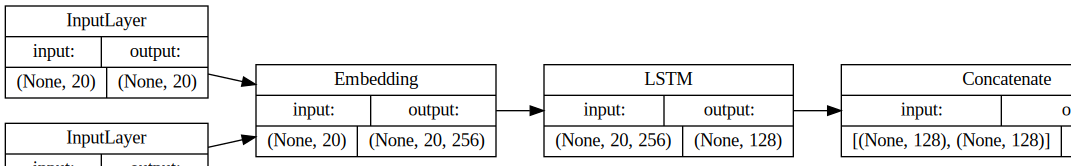

In [37]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=False, 
    rankdir='LR')

from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [38]:
from keras.optimizers import Adam

In [39]:
lr = 1e-3
opt = Adam(lr=lr, decay=lr/50)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [40]:
x1_train[:9527].shape

(9527, 20)

In [41]:
# 決定一次要放多少成對標題給模型訓練
BATCH_SIZE = 512

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 50

# 實際訓練模型
history = model.fit(
    # 輸入是兩個長度為 20 的數字序列
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    # 每個 epoch 完後計算驗證資料集
    # 上的 Loss 以及準確度
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    # 每個 epoch 隨機調整訓練資料集
    # 裡頭的數據以讓訓練過程更穩定
    shuffle=True
)

Train on 288496 samples, validate on 32056 samples
Epoch 1/50
288496/288496 [==============================] - 285s 987us/step - loss: 0.4659 - acc: 0.7845 - val_loss: 0.4015 - val_acc: 0.8170
Epoch 2/50
288496/288496 [==============================] - 284s 985us/step - loss: 0.3611 - acc: 0.8362 - val_loss: 0.3766 - val_acc: 0.8311
Epoch 3/50
288496/288496 [==============================] - 287s 996us/step - loss: 0.3255 - acc: 0.8545 - val_loss: 0.3713 - val_acc: 0.8365
Epoch 4/50
288496/288496 [==============================] - 289s 1ms/step - loss: 0.2972 - acc: 0.8686 - val_loss: 0.3732 - val_acc: 0.8399
Epoch 5/50
288496/288496 [==============================] - 287s 996us/step - loss: 0.2712 - acc: 0.8812 - val_loss: 0.3676 - val_acc: 0.8444
Epoch 6/50
288496/288496 [==============================] - 286s 991us/step - loss: 0.2493 - acc: 0.8918 - val_loss: 0.3769 - val_acc: 0.8448
Epoch 7/50
288496/288496 [==============================] - 287s 996us/step - loss: 0.2283 - acc: 0

In [42]:
import pandas as pd
if os.path.exists(TOKENIZED_TEST_CSV_PATH):
    print("Use tokenized test csv")
    test = pd.read_csv(TOKENIZED_TEST_CSV_PATH, index_col=0)
else:
    print("Use raw test csv")
    test = pd.read_csv(TEST_CSV_PATH, index_col=0)
    test.fillna('UNKNOWN', inplace=True)
    test['title1_tokenized'] = parallelize(test.loc[:, 'title1_zh'], process)
    test['title2_tokenized'] = parallelize(test.loc[:, 'title2_zh'], process)
    test.fillna('UNKNOWN', inplace=True)
test.head(3)

Use raw test csv


,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,title1_tokenized,title2_tokenized
id,,,,,,,,
321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...,萨拉 赫 人气 爆棚 埃及 总统大选 未 参选 获 百万 选票 现任 总统 压力 山 大,辟谣 里昂 官方 否认 费 基尔 加盟 利物浦 难道 是 价格 没 谈拢
321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...,萨达姆 被捕 后 告诫 美国 的 一句 话 发人深思,10 大 最 让 美国 人 相信 的 荒诞 谣言 如 蜥蜴人 掌控 着 美国
321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...,萨达姆 此项 计划 没有 此国 破坏 的话 美国 还 会 对 伊拉克 发动战争 吗,萨达姆 被捕 后 告诫 美国 的 一句 话 发人深思


In [43]:

# 將詞彙序列轉為索引數字的序列
x1_test = tokenizer \
    .texts_to_sequences(
        test.title1_tokenized)
x2_test = tokenizer \
    .texts_to_sequences(
        test.title2_tokenized)

# 為數字序列加入 zero padding
x1_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x1_test, 
        maxlen=MAX_SEQUENCE_LENGTH)
x2_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x2_test, 
        maxlen=MAX_SEQUENCE_LENGTH)    

# 利用已訓練的模型做預測
predictions = model.predict(
    [x1_test, x2_test])

In [44]:
predictions[:5]

array([[9.99981165e-01, 3.86150089e-14, 1.88565482e-05],
       [9.99804795e-01, 1.66692757e-07, 1.95083398e-04],
       [8.82719874e-01, 1.17279366e-01, 7.35057711e-07],
       [9.99994278e-01, 5.72507543e-06, 2.68289995e-08],
       [1.00000000e+00, 4.95503372e-09, 2.91800228e-09]], dtype=float32)

In [45]:
index_to_label = {v: k for k, v in label_to_index.items()}

test['Category'] = [index_to_label[idx] for idx in np.argmax(predictions, axis=1)]

submission = test \
    .loc[:, ['Category']] \
    .reset_index()

submission.columns = ['Id', 'Category']
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,Category
0,321187,unrelated
1,321190,unrelated
2,321189,unrelated
3,321193,unrelated
4,321191,unrelated


In [1]:
pip install pytorch_pretrained_bert pip install pytorch_pretrained_bert pip install pytorch_pretrained_bert pip install pytorch_pretrained_bert pip install pytorch_pretrained_bert 
pip install pytorch_pretrained_bert 
pip install pytorch_pretrained_bert 
pip install pytorch_pretrained_bert 

SyntaxError: invalid syntax (<ipython-input-1-37032c5bd914>, line 1)

In [ ]:
pip install pytorch_pretrained_bert 